<a href="https://colab.research.google.com/github/EricCallaway/COSC_6315_A04_RNN-LSTM/blob/main/ML_Assignment_04_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import necessary Libraries

In [82]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [207]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import TextVectorization
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Dropout, Bidirectional
from keras import regularizers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE

import re
import string
import contractions
import wordcloud

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

2. Import Dataset

In [84]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
train_csv = '/content/drive/MyDrive/Data/ML_A04_Dataset/SMS_train.csv'
df = pd.read_csv(train_csv, encoding="ISO-8859-1")

In [86]:
print(df.head())

   S. No.                                       Message_body     Label
0       1                         Rofl. Its true to its name  Non-Spam
1       2  The guy did some bitching but I acted like i'd...  Non-Spam
2       3  Pity, * was in mood for that. So...any other s...  Non-Spam
3       4               Will ü b going to esplanade fr home?  Non-Spam
4       5  This is the 2nd time we have tried 2 contact u...      Spam


In [87]:
# calculating length of each record in our df
df['length'] = df['Message_body'].apply(lambda x: len(x))
df.head()

,S. No.,Message_body,Label,length
0,1,Rofl. Its true to its name,Non-Spam,26
1,2,The guy did some bitching but I acted like i'd...,Non-Spam,125
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam,57
3,4,Will ü b going to esplanade fr home?,Non-Spam,36
4,5,This is the 2nd time we have tried 2 contact u...,Spam,160


In [88]:
x_df = df.Message_body
y_df = df.Label

Displaying the distribution of data. (Spam vs. Non-Spam)

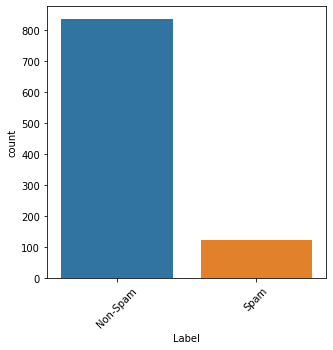

In [89]:
fig = plt.figure(figsize=(5,5))
plt.xticks(rotation=45)
sns.countplot(x='Label', data=df)

Word Cloud

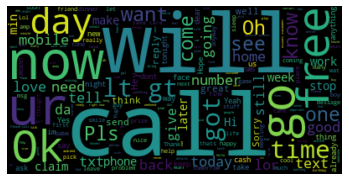

In [90]:
common_words=''
for i in df.Message_body:
  i = str(i)
  tokens = i.split()
  common_words += ' '.join(tokens)+' '
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Label Encoding

In [91]:
# Encode the target column
lb=LabelEncoder()
df['Label_Value'] = lb.fit_transform(df.Label)

In [92]:
df.head()

,S. No.,Message_body,Label,length,Label_Value
0,1,Rofl. Its true to its name,Non-Spam,26,0
1,2,The guy did some bitching but I acted like i'd...,Non-Spam,125,0
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam,57,0
3,4,Will ü b going to esplanade fr home?,Non-Spam,36,0
4,5,This is the 2nd time we have tried 2 contact u...,Spam,160,1


In [93]:
# some text cleaning functions
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def contraction_mapping(text):
  expanded_words = []
  for word in text.split():
    #using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)
  return expanded_text
  

3. Clean Text

In [94]:
df['Message_body'] = df['Message_body'].apply(lambda x: convert_to_lower(x))
df['Message_body'] = df['Message_body'].apply(lambda x: remove_numbers(x))
df['Message_body'] = df['Message_body'].apply(lambda x: remove_punctuation(x))
df['Message_body'] = df['Message_body'].apply(lambda x: remove_stopwords(x))
df['Message_body'] = df['Message_body'].apply(lambda x: remove_extra_white_spaces(x))
df['Message_body'] = df['Message_body'].apply(lambda x: lemmatizing(x))
df['Message_body'] = df['Message_body'].apply(lambda x: contraction_mapping(x))


In [95]:
df['length_after_cleaning'] = df['Message_body'].apply(lambda x: len(x))
df.head()

,S. No.,Message_body,Label,length,Label_Value,length_after_cleaning
0,1,rofl true name,Non-Spam,26,0,14
1,2,guy bitching acted like id interested buying s...,Non-Spam,125,0,83
2,3,pity mood soany suggestion,Non-Spam,57,0,26
3,4,ü going esplanade fr home,Non-Spam,36,0,25
4,5,nd time tried contact you £ pound prize claim ...,Spam,160,1,81


In [96]:
df.length.max()

446

4. Tokenize Text

Number of unique words in the dataset. In other words this is the size of the vocabulary of this dataset.

In [97]:
results = set()
df['Message_body'].str.lower().str.split().apply(results.update)
print(len(results))

2765


This performs Tokenization, Vectorization, and padding 

In [98]:
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(df.Message_body.values)
x = tokenizer.texts_to_sequences(df.Message_body)
x = pad_sequences(x)


5. Balance the Dataset

In [99]:
x_data = pd.DataFrame(x)
sm = SMOTE(sampling_strategy='minority', random_state=1337)
x_res, y_res = sm.fit_resample(x_data, df.Label_Value)

In [100]:
y_res.value_counts()

0    835
1    835
Name: Label_Value, dtype: int64

In [101]:
y_res_plot = y_res.to_frame()

In [102]:
y_res_plot.head()

,Label_Value
0,0
1,0
2,0
3,0
4,1


In [103]:
y_res_plot.value_counts()

Label_Value
0              835
1              835
dtype: int64

Notice here we have now an even dataset, both categories have 835 data points.

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

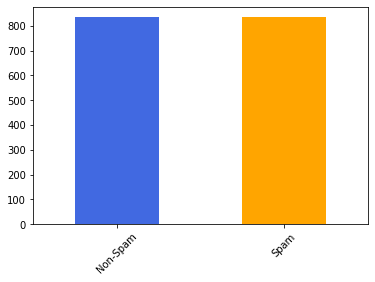

In [104]:
y_res_plot['Label_Value'].value_counts().plot(kind='bar', color=['royalblue', 'orange'])
plt.xticks([0,1], ['Non-Spam', 'Spam'])
plt.xticks(rotation=45)

In [105]:
x_res.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1027,249,161
1,0,0,0,0,0,0,0,0,0,0,...,182,474,366,140,210,101,37,367,1,11
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1029,1030,1031,643
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,29,38,644,1032,30
4,0,0,0,0,0,0,0,0,0,0,...,1,9,251,67,50,211,2,212,213,645


6. Splitting Dataset into Train, Test, and Validation sets.

Now since we want the valid  size to be equal (20% of overall data). 
We take 33.33% of the remaining data and the other 66.67% will be 20 % of the original training set for our validation set.
So the overal percentaes are training=70%, validation=20%, testing=10%

In [106]:
x_train, x_rem, y_train, y_rem = train_test_split(x_res,y_res, train_size=0.7, random_state=1337, stratify=y_res)

x_val, x_test, y_val, y_test = train_test_split(x_rem,y_rem, test_size=0.3333, random_state=1337, stratify=y_rem)

7. Build Model

In [126]:
# model = Sequential()

# model = Sequential([
#     Embedding(5000, 2, input_length=x_train.shape[1]),
#     SpatialDropout1D(0.4),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2),
#     Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
#     Dropout(0.33),
#     Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
#     Flatten(),
#     Dense(1, activation='sigmoid')
# ])



# model.add(Embedding(5000, 2, input_length=x_train.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
# model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

In [184]:
# model = Sequential([
#     Embedding(5000, 2, input_length=x_train.shape[1]),
#     SpatialDropout1D(0.4),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
#     LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2),
#     Dropout(0.33),
#     Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
#     Flatten(),
#     Dense(1, activation='sigmoid')
# ])

In [209]:
model = Sequential([
    Embedding(5000, 2, input_length=x_train.shape[1]),
    SpatialDropout1D(0.4),
    Bidirectional(LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(8, activation='relu', dropout=0.2, recurrent_dropout=0.2)),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Dropout(0.33),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

Compile Model

In [210]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Summarization of the Model

In [211]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 61, 2)             10000     
                                                                 
 spatial_dropout1d_12 (Spati  (None, 61, 2)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirectio  (None, 61, 16)           704       
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 16)               1600      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                      

8. Train Model

In [212]:
epochs=10
batch_size=32

# fit the model
history = model.fit(
  x_train,
  y_train,
  validation_data=(x_val,y_val),
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True,
  verbose='auto'
  )

Epoch 1/10
37/37 [==============================] - 19s 219ms/step - loss: 0.6948 - accuracy: 0.4816 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/10
37/37 [==============================] - 7s 188ms/step - loss: 0.6945 - accuracy: 0.4790 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/10
37/37 [==============================] - 7s 183ms/step - loss: 0.6940 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
37/37 [==============================] - 7s 192ms/step - loss: 0.8181 - accuracy: 0.6210 - val_loss: 0.6699 - val_accuracy: 0.8473
Epoch 5/10
37/37 [==============================] - 10s 269ms/step - loss: 0.6812 - accuracy: 0.5654 - val_loss: 0.6727 - val_accuracy: 0.5449
Epoch 6/10
37/37 [==============================] - 7s 185ms/step - loss: 0.6560 - accuracy: 0.6638 - val_loss: 0.6295 - val_accuracy: 0.8533
Epoch 7/10
37/37 [==============================] - 7s 190ms/step - loss: 0.6150 - accuracy: 0.6929 - val_loss: 0.5690 - val_accuracy: 0.8563
Epoc

visualizing Loss and Accuracy

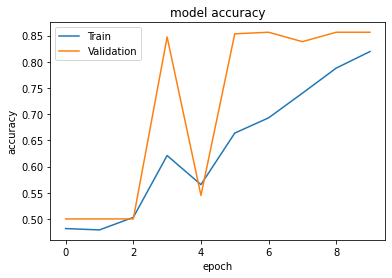

In [214]:
#Summarizing History for Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

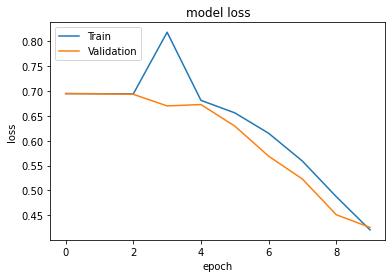

In [215]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Confusion Matrix for Training

In [216]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual')
    plt.xlabel('Prediction')

In [217]:
score = model.evaluate(x_test, y_test)
print('Test Accuracy{}'.format(score[1]))

6/6 [==============================] - 0s 27ms/step - loss: 0.4237 - accuracy: 0.8623
Test Accuracy0.8622754216194153


In [218]:
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


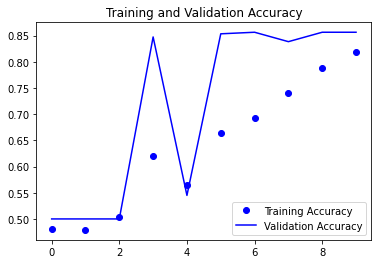

In [219]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

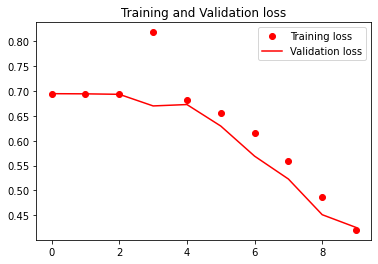

In [220]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [221]:
predicted_classes = model.predict(x_test)
y_true = y_test

In [222]:
updated_predicted_classes = predicted_classes

In [223]:
for id, x in enumerate(updated_predicted_classes):
  if x < 0.50:
    updated_predicted_classes[id] = 0.0
  elif x > 0.50:
    updated_predicted_classes[id] = 1.0

In [224]:
pred_df = pd.DataFrame(updated_predicted_classes, columns = [0])
class_predictions = pred_df

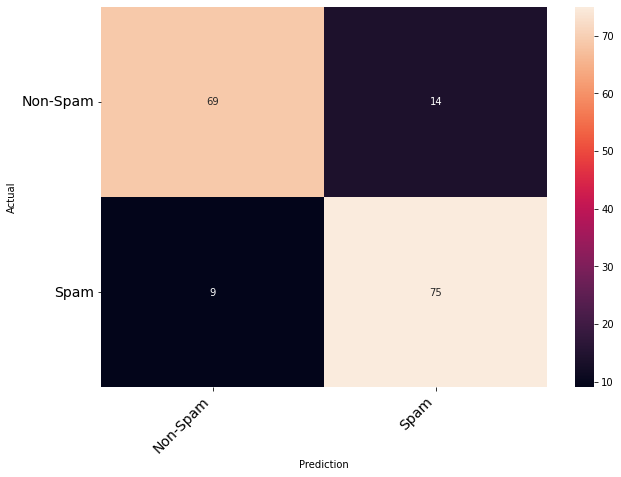

In [225]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, class_predictions)
print_confusion_matrix(cm, ["Non-Spam", "Spam"])

In [226]:
cr = classification_report(y_true, class_predictions,target_names=['Non-Spam', 'Spam'], digits=3)
print(cr)

              precision    recall  f1-score   support

    Non-Spam      0.885     0.831     0.857        83
        Spam      0.843     0.893     0.867        84

    accuracy                          0.862       167
   macro avg      0.864     0.862     0.862       167
weighted avg      0.864     0.862     0.862       167

